**Model training in three ways:**

- using images obtained with `Spectrogram` in `03_preprocessing_spectrogram.ipynb`
- using spectrograms transformed by `Spectrogram` on the fly
- using spectrograms transformed by `Spectrogram` on the fly with augmentations

In [1]:
import os
import yaml
import joblib
#
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
#
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F
#
import torchvision
from torchvision.io import read_image
from torchvision.transforms import ConvertImageDtype
#
from sklearn.model_selection import train_test_split
#
from utils.modelling import training, testing
from utils.spectrograms import get_spectrogram
from utils.augmentations import augment, masking
from utils.miscellaneous import update_stats
from utils.plot import get_figure, update_figure
#
from IPython.display import Image

In [2]:
print(torch.__version__)
print(torchaudio.__version__)
print(torchvision.__version__)

2.3.0+cu121
2.3.0+cu121
0.18.0+cu121


In [3]:
raw_path = 'data/raw/'
data_path = 'data/spectrogram/'

In [4]:
LEARNING_RATE = 0.0001

In [5]:
labels = yaml.safe_load(open('labels.yaml'))[2022]

In [6]:
X, y = zip(*labels.items())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=False)

# Modelling using images

In [7]:
device = 'cpu'

In [8]:
class Podcast(Dataset):

    def __init__(self, X, y):
        self.x = X
        self.y = y
        self.cid = ConvertImageDtype(torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        episode = self.x[idx]
        image = read_image(f'{data_path}/{episode}.png')
        return self.cid(image), int(label)

In [9]:
train = Podcast(X_train, y_train)
train_dataloader = DataLoader(train, shuffle=True)

In [10]:
test = Podcast(X_test, y_test)
test_dataloader = DataLoader(test)

In [11]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(6, 3)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(6, 3))
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(12, 6)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(12, 6))
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(18, 9)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(64, 16))
        )
        #
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.33)
        self.linear1 = nn.Linear(4096, 128)
        self.linear2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        #
        print('=' if self.training else '-', end='')
        return self.linear2(x)


model = CNNet().to(device, dtype=torch.float32)

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
filename = '04_spectrogram_images'

In [3]:
# !rm artifacts/04_spectrogram_images.joblib
# !rm artifacts/04_spectrogram_images.pt

In [14]:
if os.path.exists(f'artifacts/{filename}.pt'):
    model.load_state_dict(
        torch.load(f'artifacts/{filename}.pt')
    )
    print('!Model weights are loaded.')
    
if os.path.exists(f'artifacts/{filename}.joblib'):
    stats = joblib.load(f'artifacts/{filename}.joblib')
    print('!Training stats is loaded.')
else:
    stats = {
        'epoch': [],
        'training_loss': [],
        'testing_loss': [],
        'training_auc': [],
        'testing_auc': [],
    }
    
se = stats['epoch'][-1] if stats['epoch'] else 0

In [15]:
figure = get_figure(stats)
figure

FigureWidget({
    'data': [{'line': {'color': 'black', 'dash': 'dash', 'width': 0.5},
              'marker': {'color': 'white', 'line': {'color': 'black', 'width': 1}, 'size': 6},
              'mode': 'lines+markers',
              'name': 'Training',
              'type': 'scatter',
              'uid': 'ca484d30-c58e-42b8-acb0-1dce90125598',
              'x': [],
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'line': {'color': 'red', 'dash': 'dash', 'width': 0.5},
              'marker': {'color': 'white', 'line': {'color': 'red', 'width': 1}, 'size': 6},
              'mode': 'lines+markers',
              'name': 'Testing',
              'type': 'scatter',
              'uid': 'a2b90990-a766-4a54-8676-de4d1bfe12d7',
              'x': [],
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'line': {'color': 'black', 'dash': 'dash', 'width': 0.5},
              'marker': {'color': 'white', '

In [ ]:
for epoch in range(se, 200):
    train_loss, train_auc = training(model, optimizer, criterion, train_dataloader)
    test_loss, test_auc = testing(model, optimizer, criterion, test_dataloader)
    #
    update_stats(stats, epoch, train_loss, test_loss, train_auc, test_auc)
    update_figure(figure, stats, filename)
    #
    joblib.dump(stats, f'artifacts/{filename}.joblib')
    if epoch % 5 == 0:
        if len(stats['testing_loss']) >= 10:
            x0 = torch.tensor(stats['testing_loss'][-10:-5]).mean()
            if x0 > torch.tensor(stats['testing_loss'][-5:]).mean():
                torch.save(
                    model.state_dict(),
                    f'artifacts/{filename}.pt'
                )
                print('!Model weights were saved.')

==============================================================================--------------------------
Epoch: 0 | Training loss: 0.6470 | Testing loss: 0.5854 | Training AUC: 0.3474 | Testing AUC: 0.4436
==============================================================================--------------------------
Epoch: 1 | Training loss: 0.6121 | Testing loss: 0.5852 | Training AUC: 0.5073 | Testing AUC: 0.4361
==============================================================================--------------------------
Epoch: 2 | Training loss: 0.6238 | Testing loss: 0.5926 | Training AUC: 0.3693 | Testing AUC: 0.4436
==============================================================================--------------------------
Epoch: 3 | Training loss: 0.6237 | Testing loss: 0.5958 | Training AUC: 0.4489 | Testing AUC: 0.4511
==============================================================================--------------------------
Epoch: 4 | Training loss: 0.6302 | Testing loss: 0.5941 | Training AUC:

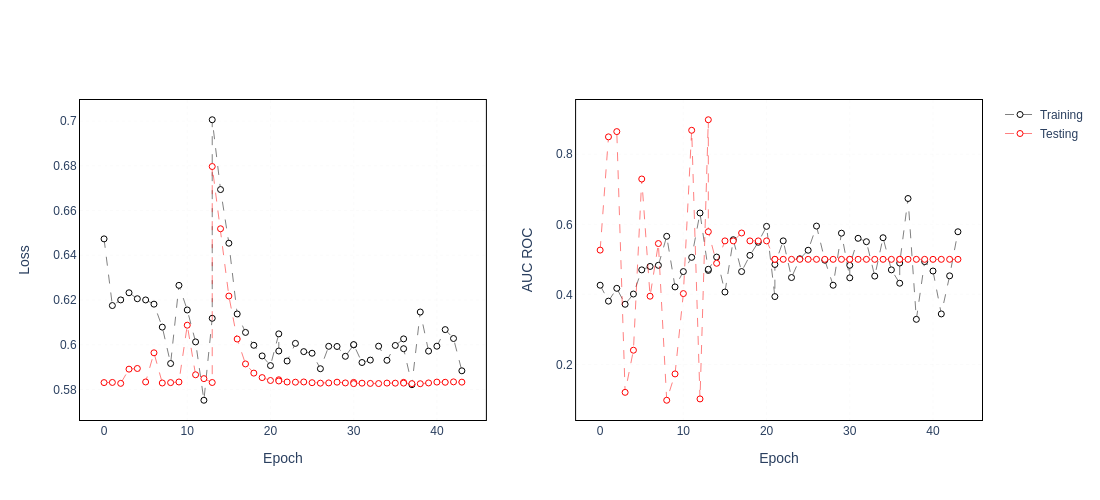

In [2]:
Image('artifacts/04_spectrogram_images.png')

# Modelling `as is`

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
from utils.spectrograms import get_spectrogram
from utils.miscellaneous import update_stats
from utils.plot import get_figure, update_figure

In [9]:
class Podcast(Dataset):

    def __init__(self, X, y):
        self.x = X
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        episode = self.x[idx]
        #
        waveform, sample_rate = torchaudio.load(f'{raw_path}/{episode}.mp3')
        #
        return get_spectrogram(waveform.mean(dim=0), sample_rate), label

In [10]:
train = Podcast(X_train, y_train)
train_dataloader = DataLoader(train, shuffle=True)

In [11]:
test = Podcast(X_test, y_test)
test_dataloader = DataLoader(test)

In [12]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(6, 3)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(6, 3))
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(12, 6)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(12, 6))
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(18, 9)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(64, 16))
        )
        #
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.33)
        self.linear1 = nn.Linear(1024, 64)
        self.linear2 = nn.Linear(64, 1)

    def forward(self, x):
        # print('.', end='')
        shapes = [x.shape]
        # print()
        x = self.layer1(x)
        shapes.append(x.shape)
        x = self.layer2(x)
        shapes.append(x.shape)
        x = self.layer3(x)
        #
        x = self.flatten(x)
        # print(x.shape)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        # print(shapes, self.training)
        print('=' if self.training else '-', end='')
        #
        return self.linear2(x)


model = CNNet().to(device, dtype=torch.float32)

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
filename = '04_spectrogram'

In [19]:
# !rm artifacts/04_spectrogram.joblib
# !rm artifacts/04_spectrogram.pt

In [15]:
if os.path.exists(f'artifacts/{filename}.pt'):
    model.load_state_dict(
        torch.load(f'artifacts/{filename}.pt')
    )
    print('!Model weights are loaded.')
    
if os.path.exists(f'artifacts/{filename}.joblib'):
    stats = joblib.load(f'artifacts/{filename}.joblib')
    print('!Training stats is loaded.')
else:
    stats = {
        'epoch': [],
        'training_loss': [],
        'testing_loss': [],
        'training_auc': [],
        'testing_auc': [],
    }
    
se = stats['epoch'][-1] if stats['epoch'] else 0

!Model weights are loaded.
!Training stats is loaded.


In [16]:
figure = get_figure(stats)
figure

FigureWidget({
    'data': [{'line': {'color': 'black', 'dash': 'dash', 'width': 0.5},
              'marker': {'color': 'white', 'line': {'color': 'black', 'width': 1}, 'size': 6},
              'mode': 'lines+markers',
              'name': 'Training',
              'type': 'scatter',
              'uid': 'a44ed0fa-0025-4b00-9359-483cd9b3fae3',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
                    49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
                    65, 66, 67, 68, 69, 70, 71, 72, 73, 73, 74, 75, 76, 77, 78, 79,
                    80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
                    96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
                    109, 109, 110, 111, 112, 113, 114, 115, 116, 117

In [18]:
for epoch in range(se, 200):
    train_loss, train_auc = training(model, optimizer, criterion, train_dataloader, device)
    test_loss, test_auc = testing(model, optimizer, criterion, test_dataloader, device)
    #
    update_stats(stats, epoch, train_loss, test_loss, train_auc, test_auc)
    update_figure(figure, stats, filename)
    #
    joblib.dump(stats, f'artifacts/{filename}.joblib')
    if epoch % 5 == 0:
        if len(stats['testing_loss']) >= 10:
            x0 = torch.tensor(stats['testing_loss'][-10:-5]).mean()
            if x0 > torch.tensor(stats['testing_loss'][-5:]).mean():
                torch.save(
                    model.state_dict(),
                    f'artifacts/{filename}.pt'
                )
                print('!Model weights were saved.')

=

/opt/conda/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)



=============================================================================--------------------------
Epoch: 181 | Training loss: 0.4102 | Testing loss: 0.5584 | Training AUC: 0.8896 | Testing AUC: 0.6992
==============================================================================--------------------------
Epoch: 182 | Training loss: 0.3662 | Testing loss: 0.5304 | Training AUC: 0.9432 | Testing AUC: 0.6767
==============================================================================--------------------------
Epoch: 183 | Training loss: 0.3471 | Testing loss: 0.5547 | Training AUC: 0.9456 | Testing AUC: 0.6541
==============================================================================--------------------------
Epoch: 184 | Training loss: 0.3870 | Testing loss: 0.5303 | Training AUC: 0.9002 | Testing AUC: 0.6842
==============================================================================--------------------------
Epoch: 185 | Training loss: 0.3555 | Testing loss: 0.5523 | Trai

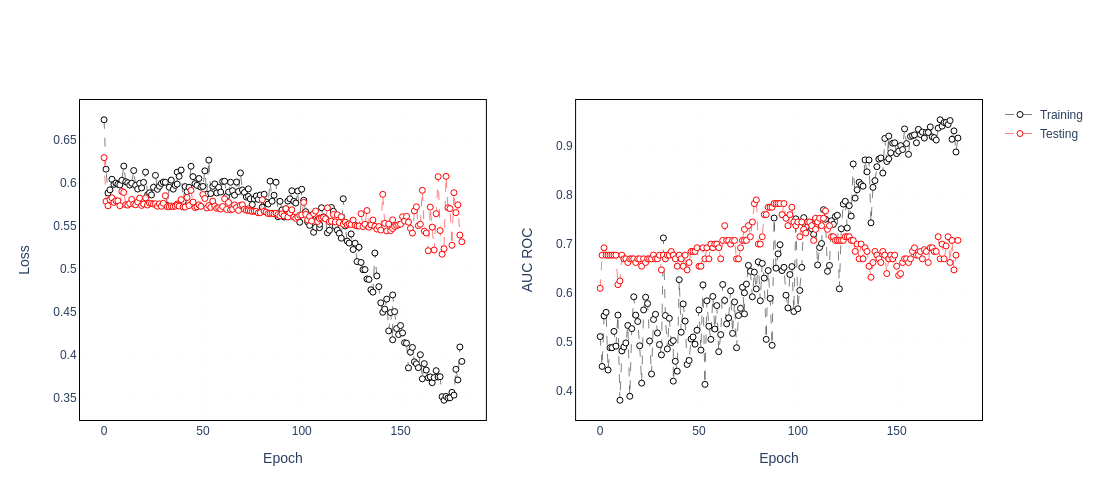

In [17]:
Image('artifacts/04_spectrogram.png')

## + augmentations

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
class Podcast(Dataset):

    def __init__(self, X, y, clipping=True, training=True):
        self.x = X
        self.y = y
        self.clipping = clipping
        self.training = training

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        episode = self.x[idx]
        #
        waveform, sample_rate = torchaudio.load(f'{raw_path}/{episode}.mp3')
        waveform = waveform.mean(dim=0)
        #
        if self.training:
            waveform = augment(waveform, sample_rate, self.clipping)
        spectrogram = get_spectrogram(waveform, sample_rate)
        if self.training:
            spectrogram = masking(spectrogram)
        #
        return spectrogram, label

In [9]:
train = Podcast(X_train, y_train)
train_dataloader = DataLoader(train, shuffle=True)

In [10]:
test = Podcast(X_test, y_test, training=False)
test_dataloader = DataLoader(test)

In [11]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(6, 3)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(6, 3))
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(12, 6)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(12, 6))
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(18, 9)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(64, 8))
        )
        #
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.33)
        self.linear1 = nn.Linear(512, 32)
        self.linear2 = nn.Linear(32, 1)

    def forward(self, x):
        # 
        shapes = [x.shape]
        # print()
        x = self.layer1(x)
        shapes.append(x.shape)
        x = self.layer2(x)
        shapes.append(x.shape)
        x = self.layer3(x)
        #
        x = self.flatten(x)
        # print(x.shape)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        # print(shapes, self.training)
        print('=' if self.training else '-', end='')
        #
        return self.linear2(x)


model = CNNet().to(device, dtype=torch.float32)

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
filename = '04_spectrogram_augmented'

In [ ]:
# !rm artifacts/04_spectrogram_augmented.joblib
# !rm artifacts/04_spectrogram_augmented.pt

In [14]:
if os.path.exists(f'artifacts/{filename}.pt'):
    model.load_state_dict(
        torch.load(f'artifacts/{filename}.pt')
    )
    print('!Model weights are loaded.')
    
if os.path.exists(f'artifacts/{filename}.joblib'):
    stats = joblib.load(f'artifacts/{filename}.joblib')
    print('!Training stats is loaded.')
else:
    stats = {
        'epoch': [],
        'training_loss': [],
        'testing_loss': [],
        'training_auc': [],
        'testing_auc': [],
    }
    
se = stats['epoch'][-1] if stats['epoch'] else 0

!Model weights are loaded.
!Training stats is loaded.


In [15]:
figure = get_figure(stats)
figure

FigureWidget({
    'data': [{'line': {'color': 'black', 'dash': 'dash', 'width': 0.5},
              'marker': {'color': 'white', 'line': {'color': 'black', 'width': 1}, 'size': 6},
              'mode': 'lines+markers',
              'name': 'Training',
              'type': 'scatter',
              'uid': '973c644e-e17c-4efb-ba4f-03a847849c6f',
              'x': [0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                    17, 18, 19, 20, 21, 22, 23, 24, 24, 25, 26, 27, 28, 29, 30, 31,
                    32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
                    48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 62,
                    63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
                    79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
                    95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107,
                    108, 109, 110, 111, 112, 113, 114, 114, 115, 116, 

In [17]:
for epoch in range(se, 200):
    train_loss, train_auc = training(model, optimizer, criterion, train_dataloader, device)
    test_loss, test_auc = testing(model, optimizer, criterion, test_dataloader, device)
    #
    update_stats(stats, epoch, train_loss, test_loss, train_auc, test_auc)
    update_figure(figure, stats, filename)
    #
    joblib.dump(stats, f'artifacts/{filename}.joblib')
    if epoch % 5 == 0:
        if len(stats['testing_loss']) >= 10:
            x0 = torch.tensor(stats['testing_loss'][-10:-5]).mean()
            if x0 > torch.tensor(stats['testing_loss'][-5:]).mean():
                torch.save(
                    model.state_dict(),
                    f'artifacts/{filename}.pt'
                )
                print('!Model weights were saved.')

=

/opt/conda/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)



=============================================================================--------------------------
Epoch: 170 | Training loss: 0.5808 | Testing loss: 0.5807 | Training AUC: 0.5974 | Testing AUC: 0.5188
!Model weights were saved.
==============================================================================--------------------------
Epoch: 171 | Training loss: 0.6117 | Testing loss: 0.5849 | Training AUC: 0.4602 | Testing AUC: 0.5489
==============================================================================--------------------------
Epoch: 172 | Training loss: 0.6110 | Testing loss: 0.5870 | Training AUC: 0.4115 | Testing AUC: 0.5263
==============================================================================--------------------------
Epoch: 173 | Training loss: 0.6026 | Testing loss: 0.5862 | Training AUC: 0.4732 | Testing AUC: 0.5338
==============================================================================--------------------------
Epoch: 174 | Training loss: 0.6024 | 

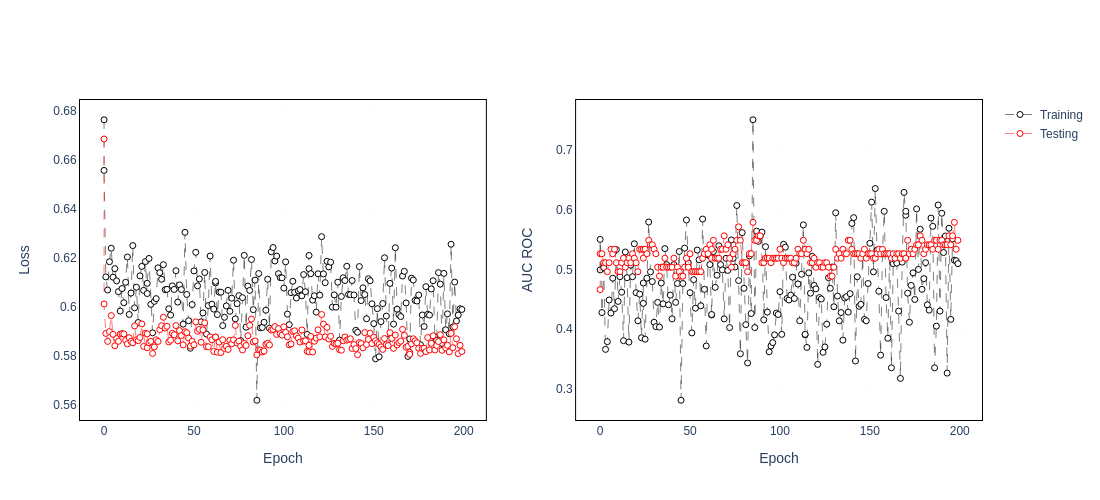

In [2]:
Image('artifacts/04_spectrogram_augmented.png')